# Régressions linéaires à l'aide de la descente de gradient

On réutilise dans ce notebook les morceaux de code établis dans la partie 3 pour réaliser les régressions linéaires de cette partie. Ils devront être légèrement adaptés suite à quelques observations qui suivent. Nous avons vu que la descente de gradient multiple convient aussi pour deux variables, autant l'utiliser tout le temps.

Il y a quelques différences avec les descentes de gradients ci-dessous vis-à-vis des versions de la partie 3. Dans les paramètres, il y a désormais $A$, $X$ et $Y$, au lieu de $X$ précédemment :
* $A$ concerne les coefficients de la droite des moindres carrés (notre ancien $X$);
* $Y$ représente une donnée connue sous forme de vecteur que nous cherchons à exprimer en fonction d'autres données connues dans $X$ qui est sous forme d'une matrice.

En fait $X$ et $Y$ vont faire partie du calcul qui détermine la fonction de régression linéaire, nos vrais paramètres sont bien dans $A$. On aurait pu donc faire le choix de mettre $X$ et $Y$ en variables globales.

In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
import pandas as pd
import os

# norm of a vector U in R^n
def norm(U):
    n = len(U)
    res = 0.0
    for i in range(n):
        res = res + U[i]**2
    return sqrt(res)

# algorithm looking for the minimum of a function f of n variables with gradient descent
def GradientDescentMulti(f, gradf, A, X, Y, alpha=1e-2, eps=1e-6, maxIter=1000):
    # gradf : gradient of f
    # A : initial vector values choosen by the user
    # alpha : learning rate (give the speed of the descent)
    # eps : precision
    # maxIter : maximum number of iterations
    N = norm(gradf(A, X, Y))
    i = 0
    while N>eps:
        A = A - alpha*gradf(A, X, Y)
        N = norm(gradf(A, X, Y))
        if i > maxIter:
            print("Failure of gradient descent after", maxIter, "iterations")
            return None
        i += 1
    return A

# algorithm computing an approximation of the gradient of f
def MultiGradient(f, X, eps=1e-6):
    n = len(X)
    Grad = np.zeros(n)
    for i in range(n):
        Eps = np.zeros(n)
        Eps[i] = eps
        Grad[i] = ( f(X+Eps) - f(X-Eps) ) / (2*eps)
    return Grad

# Algorithm looking for the minimum of a function f of n variables with gradient descent, gradient unknown
def GradientDescentMulti2(f, A, X, Y, alpha=1e-2, eps=1e-6, maxIter=1000):
    # X : initial vector values choosen by the user
    # alpha : learning rate (give the speed of the descent)
    # eps : precision
    # maxIter : maximum number of iterations
    # disp : parameter to display steps of computations
    N = 2*eps # just to start the loop
    i=0
    while N>eps:
        gradf = MultiGradient(f, A, X, Y, eps)
        N = norm(gradf)
        A = A - alpha*gradf
        if i > maxIter:
            print("Failure of gradient descent after", maxIter, "iterations")
            return None
        i += 1
    return A


La fonction suivante permet de télécharger des données à partir d'un fichier csv et de renvoyer un objet de type DataFrame dans la bibliothèque pandas de python, très commode à manipuler. On se référera à sa documentation sur le site suivant : [_documentation de pandas_](https://pandas.pydata.org/pandas-docs/stable/index.html).

In [2]:
def load_data(name):
    file_path = os.path.join("datasets", name)
    print(file_path)
    return pd.read_csv(file_path)

# Partie 4 - Régressions linéaires à l'aide de la descente de gradient

## A - Régression linéaire simple

Pour répondre à la question 4.2, voici les fonctions permettant de calculer la fonction de régression linéaire à deux variables et son gradient :

In [3]:
# J(a,b)
def twoVarLinearRegression(A, X, Y):
    m = len(X)
    res = 0.0
    for i in range(m):
        res = res + (A[0]*X[i] + A[1] - Y[i])**2
    return res/m

# grad J(a,b)
def grad_twoVarLinearRegression(A, X, Y):
    m = len(X)
    grad = np.array([0.0, 0.0])
    for i in range(m):
        tmp = A[0]*X[i] + A[1] - Y[i]
        grad[0] = grad[0] + X[i]*tmp
        grad[1] = grad[1] + tmp
    return 2.0/m * grad

Remarque : on pourrait optimiser leurs calculs en regroupant certains calculs redondants mais ce n'est pas l'objet de notre étude.

### Application : concentration en ozone
Toute cette partie illustre la question 4.3.

Nous disposons des données quotidiennes dans le fichier *ozone.csv* de la concentration en ozone en fonction de divers paramètres dont les températures à 9h, 12h et 15h notées respectivement T9, T12 et T15. En voici l'aperçu :

In [4]:
# chargement des données dans l'objet DataFrame ozone et affichage des premières lignes
ozone = load_data("ozone.csv")
ozone.head()

datasets\ozone.csv


maxO3    T9   T12   T15  Ne9  Ne12  Ne15     Vx9    Vx12    Vx15  \
20010601     87  15.6  18.5  18.4    4     4     8  0.6946 -1.7101 -0.6946   
20010602     82  17.0  18.4  17.7    5     5     7 -4.3301 -4.0000 -3.0000   
20010603     92  15.3  17.6  19.5    2     5     4  2.9544  1.8794  0.5209   
20010604    114  16.2  19.7  22.5    1     1     0  0.9848  0.3473 -0.1736   
20010605     94  17.4  20.5  20.4    8     8     7 -0.5000 -2.9544 -4.3301   

          maxO3v   vent pluie  
20010601      84   Nord   Sec  
20010602      87   Nord   Sec  
20010603      82    Est   Sec  
20010604      92   Nord   Sec  
20010605     114  Ouest   Sec

On peut également avoir un aperçu de nos données pour savoir à peu prêt quoi rechercher avec la méthode *describe()* qui réalise une étude statistique rapide sur l'objet de type DataFrame, et aussi regarder si les données sont simplement corrélées entre elles avec la méthode *corr()*. On regardera plus en détail ce qu'il se passe pour *maxO3*.

In [5]:
# quelques statistiques sur les colonnes à partir du DataFrame ozone
ozone.describe()

maxO3          T9         T12         T15         Ne9        Ne12  \
count  112.000000  112.000000  112.000000  112.000000  112.000000  112.000000   
mean    90.303571   18.360714   21.526786   22.627679    4.928571    5.017857   
std     28.187225    3.122726    4.042321    4.530859    2.594916    2.281860   
min     42.000000   11.300000   14.000000   14.900000    0.000000    0.000000   
25%     70.750000   16.200000   18.600000   19.275000    3.000000    4.000000   
50%     81.500000   17.800000   20.550000   22.050000    6.000000    5.000000   
75%    106.000000   19.925000   23.550000   25.400000    7.000000    7.000000   
max    166.000000   27.000000   33.500000   35.500000    8.000000    8.000000   

             Ne15         Vx9        Vx12        Vx15      maxO3v  
count  112.000000  112.000000  112.000000  112.000000  112.000000  
mean     4.830357   -1.214346   -1.611004   -1.690683   90.571429  
std      2.332259    2.632742    2.795673    2.810198   28.276853  
min      0.000000   -7.878500   -7.878500   -9.000000   42.000000  
25%      3.000000   -3.276450   -3.564700   -3.939200   71.000000  
50%      5.000000   -0.866000   -1.879400   -1.549650   82.500000  
75%      7.000000    0.694600    0.000000    0.000000  106.000000  
max      8.000000    5.196200    6.577800    5.000000  166.000000

In [6]:
# calcul de la matrice de corrélation du DataFrame ozone et affichage de corrélations avec maxO3
correlation_matrix = ozone.corr()
correlation_matrix["maxO3"]

maxO3     1.000000
T9        0.699387
T12       0.784262
T15       0.774570
Ne9      -0.621704
Ne12     -0.640751
Ne15     -0.478302
Vx9       0.527623
Vx12      0.430796
Vx15      0.391899
maxO3v    0.684516
Name: maxO3, dtype: float64

La température à midi a un coefficient de corrélation relativement correct pour la concentration maximale d'ozone, ce qui induit qu'une régression linéaire simple peut avoir du sens.

Représentons *maxO3* en fonction de *T12* via un nuage de points.

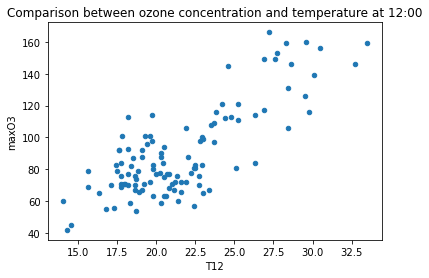

In [7]:
graph = ozone.plot(kind="scatter", x="T12", y="maxO3", title="Comparison between ozone concentration and temperature at 12:00")

On souhaite déterminer grâce à la descente de gradient la droite des moindres carrés (RMSE) de la forme $y=ax+b$, où $y$ représente *maxO3* et $x$ représente *T12*. Il faut donc initialiser les coefficients $a$ et $b$ pour démarrer l'algorithme. Plutôt que de prendre n'importe quoi et épargner à notre programme du temps calculs en prenant un point $A=(a;b)$ trop éloigné de minimum de RMSE, vu qu'on a un graphique, autant l'utiliser et déterminer "à vue" des coefficients qui paraissent cohérents. Souvenez-vous en effet que le point d'initialisation peut impacter vos calculs.

En observant le nuage de point seul, j'estime grossièrement que $y = 3x -35$ semble aller (vous pourriez estimer autre chose bien entendu). J'utiliserai donc par la suite l'initialisation $A=(3;-35)$. Construisons la droite $y=3x-35$ et ajoutons-là au nuage de points.

<AxesSubplot:title={'center':'Comparison between ozone concentration and temperature at 12:00'}, xlabel='T12', ylabel='maxO3'>

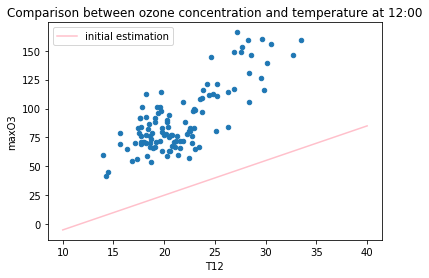

In [8]:
X = np.linspace(10.0,40.0,59)
Y1 = 3*X - 35
df = pd.DataFrame({'initial estimation': Y1}, index=X)
graph = ozone.plot(kind="scatter", x="T12", y="maxO3", title="Comparison between ozone concentration and temperature at 12:00")
df.plot(kind="line", ax=graph, color={"initial estimation": "pink"})

Bon, j'ai tapé un peu à côté mais en ne regardant pas le graphique, j'aurai pu faire pire comme point d'initialisation. Je pourrai reprendre un point $A$ plus précis (traversant le nuage de point) cependant je me contenterai de ce $A$ pour la suite. Mais je ne doute pas que vous auriez fait mieux que moi ! ;-)

On a besoin pour $Y = $ *maxO3* et $X = $ *T12* qu'ils soient de type *array* vu la façon dont sont codés nos fonctions. Les deux lignes suivantes créent *maxO3* et *T12* comme *arrays* à partir d'objet de type *pandas.Series* que sont *ozone["maxO3"]* et *ozone["T12"]*.

In [9]:
maxO3 = ozone["maxO3"].array
T12 = ozone["T12"].array

Réalisons la descente de gradient pour trouver RMSE :

In [10]:
A = np.array([3.,35.])
GradientDescentMulti(twoVarLinearRegression, grad_twoVarLinearRegression, A, T12, maxO3, alpha=1e-2, eps=1e-3, maxIter=100000)

<ipython-input-1-d2da417a2536>:15: RuntimeWarning: overflow encountered in double_scalars
  res = res + U[i]**2
<ipython-input-1-d2da417a2536>:28: RuntimeWarning: invalid value encountered in subtract
  A = A - alpha*gradf(A, X, Y)


array([nan, inf])

Là, typiquement, ça fait mal. On obtient un array contenant "not a number" et "infini". Dure est la vie du programmeur. Quoique !

Il faut investiguer sur les raisons qui nous font aboutir à cela. Quelques causes possibles vis-à-vis de ce qu'on a déjà répertoriées et des warnings ci-dessus :
* un taux d'apprentissage inadapté
* précision trop fine
* données avec de grands nombres
* somme de termes n'apportant pas davantage d'informations

Là en l'occurrence, en affichant la norme, on se rend compte qu'elle croit très vite vers un dépassement (avec nos paramètres). Au final, avons-nous besoin de calculer la norme ? Pas vraiment. On a simplement besoin de savoir si on dépasse $\varepsilon$ lors de son calcul. Autant arrêter de la calculer dès dépassement de $\varepsilon$. Dans ce sens, on remplace *norm* par *pseudo_norm*.

En affichant les valeurs de $A$ et de son gradient, on observe aussi que la précision est trop forte et peu adaptées à la taille de nos données (entre 1 et 100), on testera avec une précision à $\varepsilon=1$.

Voici donc les fonctions modifiées (vigilance si vous relancez partiellement ce notebook ultérieurement) :

In [11]:
# computes the norm of a vector U in R^n if it is smaller than eps, else give a result higher than eps
def pseudo_norm(U, eps):
    n = len(U)
    res = 0.0
    for i in range(n):
        res = res + U[i]**2
        # for high norms, res can be huge, if sufficiently huge, stop the computation
        if res>eps*eps:
            return eps+1
    return sqrt(res)

# Algorithm looking for the minimum of a function f of n variables with gradient descent
def GradientDescentMulti(f, gradf, A, X, Y, alpha=1e-2, eps=1e-6, maxIter=1000):
    # gradf : gradient of f
    # X : initial vector values choosen by the user
    # alpha : learning rate (give the speed of the descent)
    # eps : precision
    # maxIter : maximum number of iterations
    N = pseudo_norm(gradf(A, X, Y), eps)
    i = 0
    while N>eps:
        A = A - alpha*gradf(A, X, Y)
        # print(A)
        N = pseudo_norm(gradf(A, X, Y), eps)
        if i > maxIter:
            print("Failure of gradient descent after", maxIter, "iterations")
            return None
        i += 1
    return A

# Algorithm computing an approximation of the gradient of f
def MultiGradient(f, X, eps=1e-6):
    n = len(X)
    Grad = np.zeros(n)
    for i in range(n):
        Eps = np.zeros(n)
        Eps[i] = eps
        Grad[i] = ( f(X+Eps) - f(X-Eps) ) / (2*eps)
    return Grad

# Algorithm looking for the minimum of a function f of n variables with gradient descent, gradient unknown
def GradientDescentMulti2(f, A, X, Y, alpha=1e-2, eps=1e-6, maxIter=1000):
    # X : initial vector values choosen by the user
    # alpha : learning rate (give the speed of the descent)
    # eps : precision
    # maxIter : maximum number of iterations
    # disp : parameter to display steps of computations
    N = eps+1 # just to start the loop
    i=0
    while N>eps:
        gradf = MultiGradient(f, A, X, Y, eps)
        N = pseudo_norm(gradf, eps)
        A = A - alpha*gradf
        if i > maxIter:
            print("Failure of gradient descent after", maxIter, "iterations")
            return None
        i += 1
    return A


In [12]:
A = np.array([3.,35.])
GradientDescentMulti(twoVarLinearRegression, grad_twoVarLinearRegression, A, T12, maxO3, alpha=1e-3, eps=1, maxIter=100000)

array([  4.80333782, -12.59735788])

Maintenant que nous avons trouvé des coefficients $A$, la RMSE a approximativement pour équation $y = 4.8x -12.6$, que nous allons représenter via *Y2* sur notre nuage de points.

<AxesSubplot:title={'center':'Comparison between ozone concentration and temperature at 12:00'}, xlabel='T12', ylabel='maxO3'>

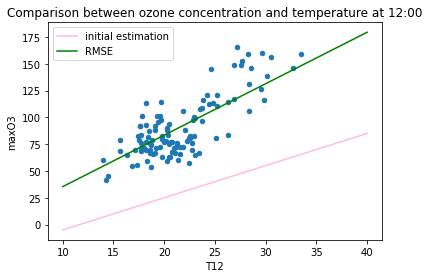

In [13]:
X = np.linspace(10.0,40.0,59)
Y1 = 3*X - 35
Y2 = 4.8*X - 12.6
df = pd.DataFrame({'initial estimation': Y1, 'RMSE': Y2}, index=X)
graph = ozone.plot(kind="scatter", x="T12", y="maxO3", title="Comparison between ozone concentration and temperature at 12:00")
df.plot(kind="line", ax=graph, color={"initial estimation": "pink", "RMSE": "green"})

Estimer la valeur de *maxO3* en $\mu g.m^{-3}$ pour une température de 40°C.

In [14]:
4.8*40-12.6

179.4

### Premiers constats
On peut remarquer que les quelques calculs sur une centaine de données peuvent déjà prendre un peu de temps (quelques secondes). Bien entendu, des optimisations sont possibles, et les bibliothèques que vous manipulerez seront plus optimales que les algorithmes pédagogiques que vous voyez ici. Il faut donc déjà constater qu'il est important de :
* **Préparer les données :** les transformer avant traitement peut limiter des problèmes et standardiser vos fonctions (centrer, normer, peut éviter des dépassements mémoire) pourra limiter des problèmes lors de vos recherches ;
* **Echantillonner :** je ne l'ai pas fait (et c'est mal !) mais j'aurai pu trouver à peu près la même RMSE avec un échantillon de données qui aurait permis appprentissage. En prenant toutes les données, il n'y a pas d'apprentissage, et même risque d'avoir une mauvaise RMSE aboutissant à de mauvaises prédictions. Par exemple, le cas où deux données sont identiques sauf pour un critère où pour l'une c'est oui et l'autre non. Echantillonner, c'est important (et ça limite le volume de calcul aussi) ;
* **Analyser les calculs :** regardez ce que donnent vos calculs quitte à ajouter des commentaires dans vos fonctions pour en voir le comportement pour ajuster vos paramètres
* **Expérimenter :** quelques idées pour tester rapidement peuvent émerger, réaliser des boucles de tests où chaque boucle modifie un paramètre et pourquoi pas intelligemment en s'adaptant si la boucle précédente était peu fructueuse ?


## B - Régression linéaire multiple

On pourrait étendre les algorithmes réalisés précédemment à plusieurs variables assez facilement. Pour cette partie, cela revient à les retoucher en considérant des matrices. Cela nécessite un peu de réflexion et de naviguer dans la documentation python. Nous allons voir une autre façon de faire, qui utilise le calcul matriciel au lieu de la descente du gradient, décrit dans le document word.

Il est important de noter que la descente du gradient et le calcul matriciel aboutiront à des résultats similaires et proches. Le calcul matriciel a l'avantage de donner un résultat par calcul "direct" mais pas forcément simple à calculer si la matrice est trop grande, des problèmes de mémoire et dépassements. Tandis que la descente du gradient pourra plus aisément se faire mais souffrira des mêmes problèmes évoqués dans la partie précédente.

### Application : attaques cardiaques

In [169]:
# chargement des données dans l'objet DataFrame heart_attacks et affichage des premières lignes
heart_attacks = load_data("attaques_cardiaques.csv")
heart_attacks.head()

datasets\attaques_cardiaques.csv


Pays   X1  X2  X3   Y
0  Australie  124  33   8  81
1   Autriche   49  31   6  55
2     Canada  181  38   8  80
3     Ceylan    4  17   2  24
4      Chili   22  20   4  78

In [170]:
# quelques statistiques sur les colonnes à partir du DataFrame heart_attacks
heart_attacks.describe()

X1         X2         X3          Y
count   22.000000  22.000000  22.000000  22.000000
mean    82.545455  30.318182   5.636364  56.727273
std     76.458970   8.687081   1.865615  19.307491
min      4.000000   8.000000   2.000000  24.000000
25%     18.250000  23.500000   4.000000  43.500000
50%     51.500000  32.000000   6.000000  52.000000
75%    145.000000  38.000000   7.000000  71.250000
max    254.000000  40.000000   8.000000  89.000000

In [171]:
# calcul de la matrice de corrélation du DataFrame heart_attacks et affichage de corrélations
correlation_matrix = heart_attacks.corr()
correlation_matrix

X1        X2        X3         Y
X1  1.000000  0.688268  0.777954  0.518188
X2  0.688268  1.000000  0.830182  0.446281
X3  0.777954  0.830182  1.000000  0.621102
Y   0.518188  0.446281  0.621102  1.000000

In [173]:
#var_list[0]
U = np.delete(heart_attacks.values, 0, axis=1) # on retire la première colonne qui contient du texte
U = U.astype('float') # on change le type des éléments de X en int, ils étaient auparavant de type object
Y = copy(U[:,-1]) # on récupère la dernière colonne de U qui contient Y
U = np.delete(U, -1, axis=1) # on retire la dernière colonne de U qui contient Y
print("Y = ")
print(Y)
print("U = ")
print(U)

Y = 
[81. 55. 80. 24. 78. 52. 88. 45. 50. 69. 66. 45. 24. 43. 38. 72. 41. 38.
 52. 52. 66. 89.]
U = 
[[124.  33.   8.]
 [ 49.  31.   6.]
 [181.  38.   8.]
 [  4.  17.   2.]
 [ 22.  20.   4.]
 [152.  39.   6.]
 [ 75.  30.   7.]
 [ 54.  29.   7.]
 [ 43.  35.   6.]
 [ 41.  31.   5.]
 [ 17.  23.   4.]
 [ 22.  21.   3.]
 [ 16.   8.   3.]
 [ 10.  23.   3.]
 [ 63.  37.   6.]
 [170.  40.   8.]
 [ 15.  38.   6.]
 [ 15.  25.   4.]
 [221.  39.   7.]
 [171.  33.   7.]
 [ 97.  38.   6.]
 [254.  39.   8.]]


In [174]:
m = U.shape[0]
Ones = np.ones((m, 1)) # une matrice de dimensions mx1 ne contenant que des 1
X = np.concatenate((Ones, U), axis=1) # on construit X =[Ones, U] en concaténant la colonne de 1 avec U (sur l'axe des colonnes)
print(X)

[[  1. 124.  33.   8.]
 [  1.  49.  31.   6.]
 [  1. 181.  38.   8.]
 [  1.   4.  17.   2.]
 [  1.  22.  20.   4.]
 [  1. 152.  39.   6.]
 [  1.  75.  30.   7.]
 [  1.  54.  29.   7.]
 [  1.  43.  35.   6.]
 [  1.  41.  31.   5.]
 [  1.  17.  23.   4.]
 [  1.  22.  21.   3.]
 [  1.  16.   8.   3.]
 [  1.  10.  23.   3.]
 [  1.  63.  37.   6.]
 [  1. 170.  40.   8.]
 [  1.  15.  38.   6.]
 [  1.  15.  25.   4.]
 [  1. 221.  39.   7.]
 [  1. 171.  33.   7.]
 [  1.  97.  38.   6.]
 [  1. 254.  39.   8.]]


Pour réaliser un produit matriciel, on utilise *np.dot*, ci-dessous le calcul de $X^T\cdot X$ :

In [164]:
V = np.dot(X.T, X)
V

array([[2.20000e+01, 1.81600e+03, 6.67000e+02, 1.24000e+02],
       [1.81600e+03, 2.72668e+05, 6.46580e+04, 1.25660e+04],
       [6.67000e+02, 6.46580e+04, 2.18070e+04, 4.04200e+03],
       [1.24000e+02, 1.25660e+04, 4.04200e+03, 7.72000e+02]])

La fonction $inv$ permet de donner l'inverse d'une matrice carrée inversible.

In [165]:
inv(V)

array([[ 8.69390295e-01,  2.24911693e-03, -2.00200902e-02,
        -7.14321180e-02],
       [ 2.24911693e-03,  2.09400797e-05, -2.51581727e-05,
        -5.70381096e-04],
       [-2.00200902e-02, -2.51581727e-05,  2.06049821e-03,
        -7.16308936e-03],
       [-7.14321180e-02, -5.70381096e-04, -7.16308936e-03,
         5.95572522e-02]])

En assemblant ce que nous venons de voir, nous pouvons calculer numériquement $a$ :

In [166]:
a = np.dot(np.dot(inv(V), X.T), Y)
a

array([27.82783081,  0.02886538, -0.53058149,  7.55859716])

Visualisons ce que donne l'écart entre notre donnée $Y$ et le calcul de $Xa$ avec notre estimation de $a$.

In [167]:
np.dot(X,a)-Y

array([-6.63327403e+00,  3.14579109e+00, -6.64085480e+00,  1.00406012e+01,
       -2.99143721e+01,  4.87427334e+00, -2.10145304e+01,  2.19098781e+01,
        5.85027282e+00, -1.86437291e+01, -1.96504435e+01, -5.00355073e+00,
        2.27208164e+01, -4.41109828e+00,  1.73664174e+01, -1.95369811e-02,
        1.24502977e+01,  7.23066279e+00,  1.44245818e+01,  1.61648017e+01,
       -1.01827411e+01, -1.40642635e+01])

Ce dernier résultat représente un vecteur des écarts indice par indice de sorte que $||Xa-y||$ soit minimal. Si on calcule sa somme des $\varepsilon_i$, il sera relativement élevé vu que ce vecteur contient déjà certaines valeurs bien éloignées de 0. La régression se montre pas si précise qu'on l'espérait. Le choix des variables n'est peut-être pas pertinent, ou prendre toutes les valeurs de données n'est pas pertinent.